# Ejercicio Ridge, Lasso y ElasticNet
Para este ejercicio vas a trabajar con datos de ventas de una empresa que fabrica muebles en España. Esta empresa es una Pyme que demanda conocer de antemano qué ingresos va a tener cada mes, ya que necesita pedir un anticipio a su entidad financiera de cara a poder abastecerse de materia prima al comenzar el mes. Como desconoce cuánto tiene que pedir, tira al alza y acaba pagando muchos intereses. El objetivo es reducir estos gastos.

En las bases de datos de la empresa constan todos los gastos en publicidad y ventas, para cada uno de los meses desde su fundación (hace más de 15 años).

Dado que los presupuestos de marketing se cierran al principio de cada mes, la empresa necesita un modelo predictivo que le anticipe las ventas que conseguirá a final de mes en función de los gastos que realizará en marketing.

Para ello tendrás que utilizar tanto modelos de regresión normales, como regularizados.

1. Carga los datos y realiza un pequeño análisis exploratorio. Mira a ver cómo se relaciona las ventas con el resto de variables.
2. Crea varios modelos y modifica los hiperparámetros necesarios para mejorar el performance del modelo.
3. Interpreta los resultados. Traduce a una fórmula tu mejor modelo (escribir la fórmula simplemente). ¿Cuánto cambian las ventas si aumentamos la inversión en radio un punto más? ¿Y si aumentamos la inversión en TV o periódicos?

## Import libraries 

In [199]:
import numpy as np
import pandas as pd
from sklearn import linear_model, metrics, model_selection
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import seaborn as sns


## Exploratory Data Analysis 

In [218]:
df = pd.read_csv('data/Advertising.csv')
df.head()

,Unnamed: 0,TV,radio,newpaper,sales
0,0,230.1,37.8,6s9.2,22100.0
1,1,44.5,39.3,45.1,10400.0
2,2,17.2,45.9,69.3,9300.0
3,3,151.5,41.3,58.5,18500.0
4,4,180.8,10.8,58.4,12900.0


In [220]:
# Eliminar la columna 'Unnamed: 0' 
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Ver qué valor raro hay en la fila 1 columna 'newspaper'
print("Valor original:", df.loc[1, 'newpaper'])

# Corregir el valor '6s9.2' en newspaper (lo cambiamos a NaN o a un valor válido)
df.loc[1, 'newpaper'] = pd.to_numeric(df.loc[1, 'newpaper'], errors='coerce')

# Si querés eliminar directamente la fila 1 (en lugar de corregirla), podés hacer:
# df = df.drop(index=1)

# Convertir toda la columna a float (por si quedó como object)
df['newpaper'] = pd.to_numeric(df['newpaper'], errors='coerce')

# Si hay valores NaN (como el que acabamos de forzar), los quitamos
df = df.dropna()

# Reiniciar índice si hace falta
df = df.reset_index(drop=True)

# Verificar
print(df.head())
print(df.dtypes)

Valor original: 45.1
      TV  radio  newpaper    sales
0   44.5   39.3      45.1  10400.0
1   17.2   45.9      69.3   9300.0
2  151.5   41.3      58.5  18500.0
3  180.8   10.8      58.4  12900.0
4    8.7   48.9      75.0   7200.0
TV          float64
radio       float64
newpaper    float64
sales       float64
dtype: object


In [221]:
df.describe()

,TV,radio,newpaper,sales
count,199.000000,199.000000,199.000000,199.000000
mean,146.625126,23.190955,30.359799,13981.909548
std,85.867111,14.848182,21.659246,5198.861022
min,0.700000,0.000000,0.300000,1600.000000
25%,74.050000,9.950000,12.700000,10350.000000
50%,149.700000,22.500000,25.600000,12900.000000
75%,218.450000,36.400000,44.700000,17350.000000
max,296.400000,49.600000,114.000000,27000.000000


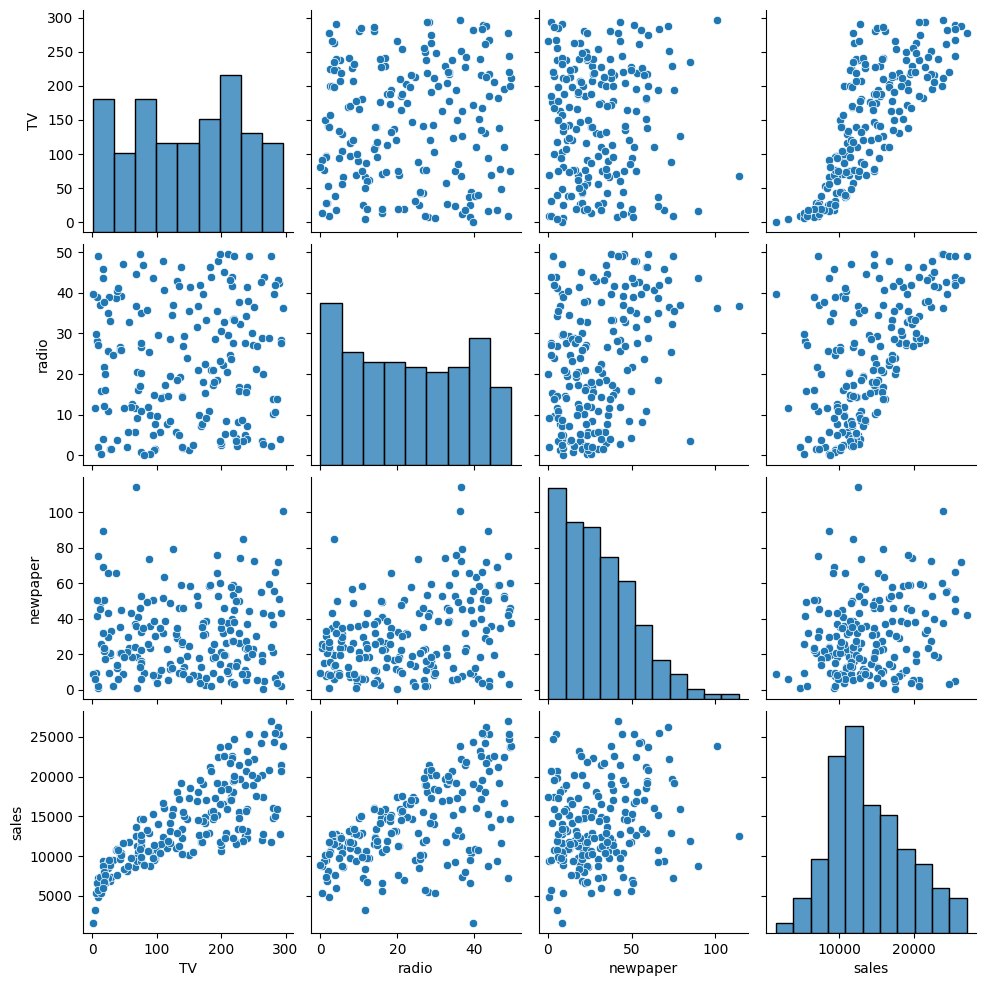

In [226]:
# Verificar correlación
sns.pairplot(df)
plt.show()



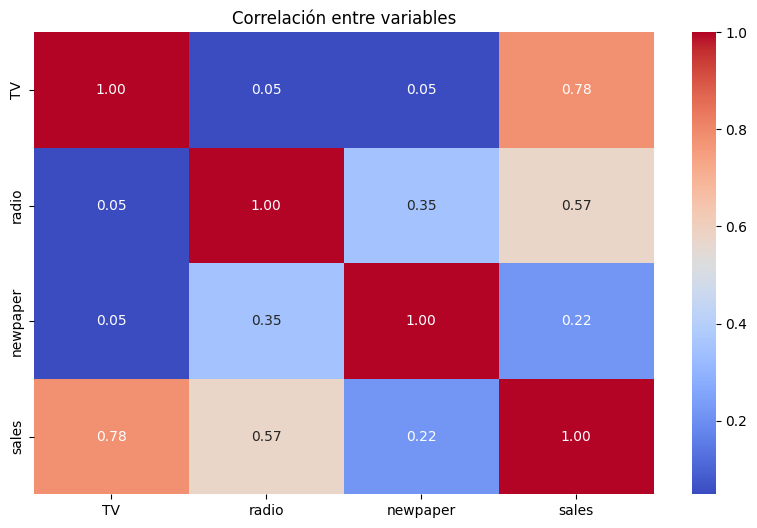

In [225]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlación entre variables")
plt.show()

## Modelado

# **Polynomial Regression**

In [246]:
# scalar los datos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [247]:
# train : the first rows 
# test : the last rows 
n_split = 60
X_train = df.iloc[:n_split,0:-2] 
X_test = df.iloc[n_split:,0:-2]
y_train = df.iloc[:n_split,-1] 
y_test = df.iloc[n_split:,-1]  

In [228]:
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
baseline_error = metrics.mean_squared_error(y_test, y_pred)

print("Train MSE:", metrics.mean_squared_error(y_train, lr.predict(X_train)))
print("Test MSE:", metrics.mean_squared_error(y_test, lr.predict(X_test)))
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, lr.predict(X_test))))

Train MSE: 2734261.723623478
Test MSE: 2818465.712661076


In [229]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60, 2)
(139, 2)
(60,)
(139,)


In [230]:
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
baseline_error = metrics.mean_squared_error(y_test, y_pred)

print("Train MSE:", metrics.mean_squared_error(y_train, lr.predict(X_train)))
print("Test MSE:", metrics.mean_squared_error(y_test, lr.predict(X_test)))
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, lr.predict(X_test))))

Train MSE: 2734261.723623478
Test MSE: 2818465.712661076
Test RMSE: 1678.8286728136006


In [231]:
from sklearn.linear_model import Ridge

ridgeR = Ridge(alpha = 0.001)
ridgeR.fit(X_train, y_train)

print("Train MSE sin regularización:", round(metrics.mean_squared_error(y_train, lr.predict(X_train)),2))
print("Test MSE sin regularización:", round(metrics.mean_squared_error(y_test, lr.predict(X_test)),2))

print("Train MSE con regularización:", round(metrics.mean_squared_error(y_train, ridgeR.predict(X_train)),2))
print("Test MSE con regularización:", round(metrics.mean_squared_error(y_test, ridgeR.predict(X_test)),2))
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, ridgeR.predict(X_test))))

Train MSE sin regularización: 2734261.72
Test MSE sin regularización: 2818465.71
Train MSE con regularización: 2734261.72
Test MSE con regularización: 2818465.67
Test RMSE: 1678.8286594527792


In [234]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Variables
X = df[['TV', 'radio', 'newpaper']]
y = df['sales']

# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modelos
models = {
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5)
}

# Entrenar y evaluar
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"--- {name} ---")
    print("R2 Score:", r2_score(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("Coeficientes:", model.coef_)
    print("Intercepto:", model.intercept_)
    print()


--- Ridge ---
R2 Score: 0.8747486489661035
MSE: 2492939.482482216
Coeficientes: [3993.80050468 2779.69262439   12.88848296]
Intercepto: 13929.081467315034

--- Lasso ---
R2 Score: 0.8733917582410369
MSE: 2519946.3485480123
Coeficientes: [4017.70604193 2798.71516976    4.57738351]
Intercepto: 13927.357100969573

--- ElasticNet ---
R2 Score: 0.8816106747633867
MSE: 2356361.19491365
Coeficientes: [3834.5435979  2655.13750754   63.9158147 ]
Intercepto: 13940.528943104693



In [238]:
n_alphas = 100
alphas = np.logspace(-4, 3, n_alphas) 

coef_ridge = []
err_ridge = []
baseline = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    
    coef_ridge.append(ridge.coef_)
    
    y_pred = ridge.predict(X_test)
    ridge_error = metrics.mean_squared_error(y_pred, y_test)
    
    err_ridge.append(ridge_error)
    baseline.append(baseline_error)

In [245]:
min(err_ridge)

2290341.960172633

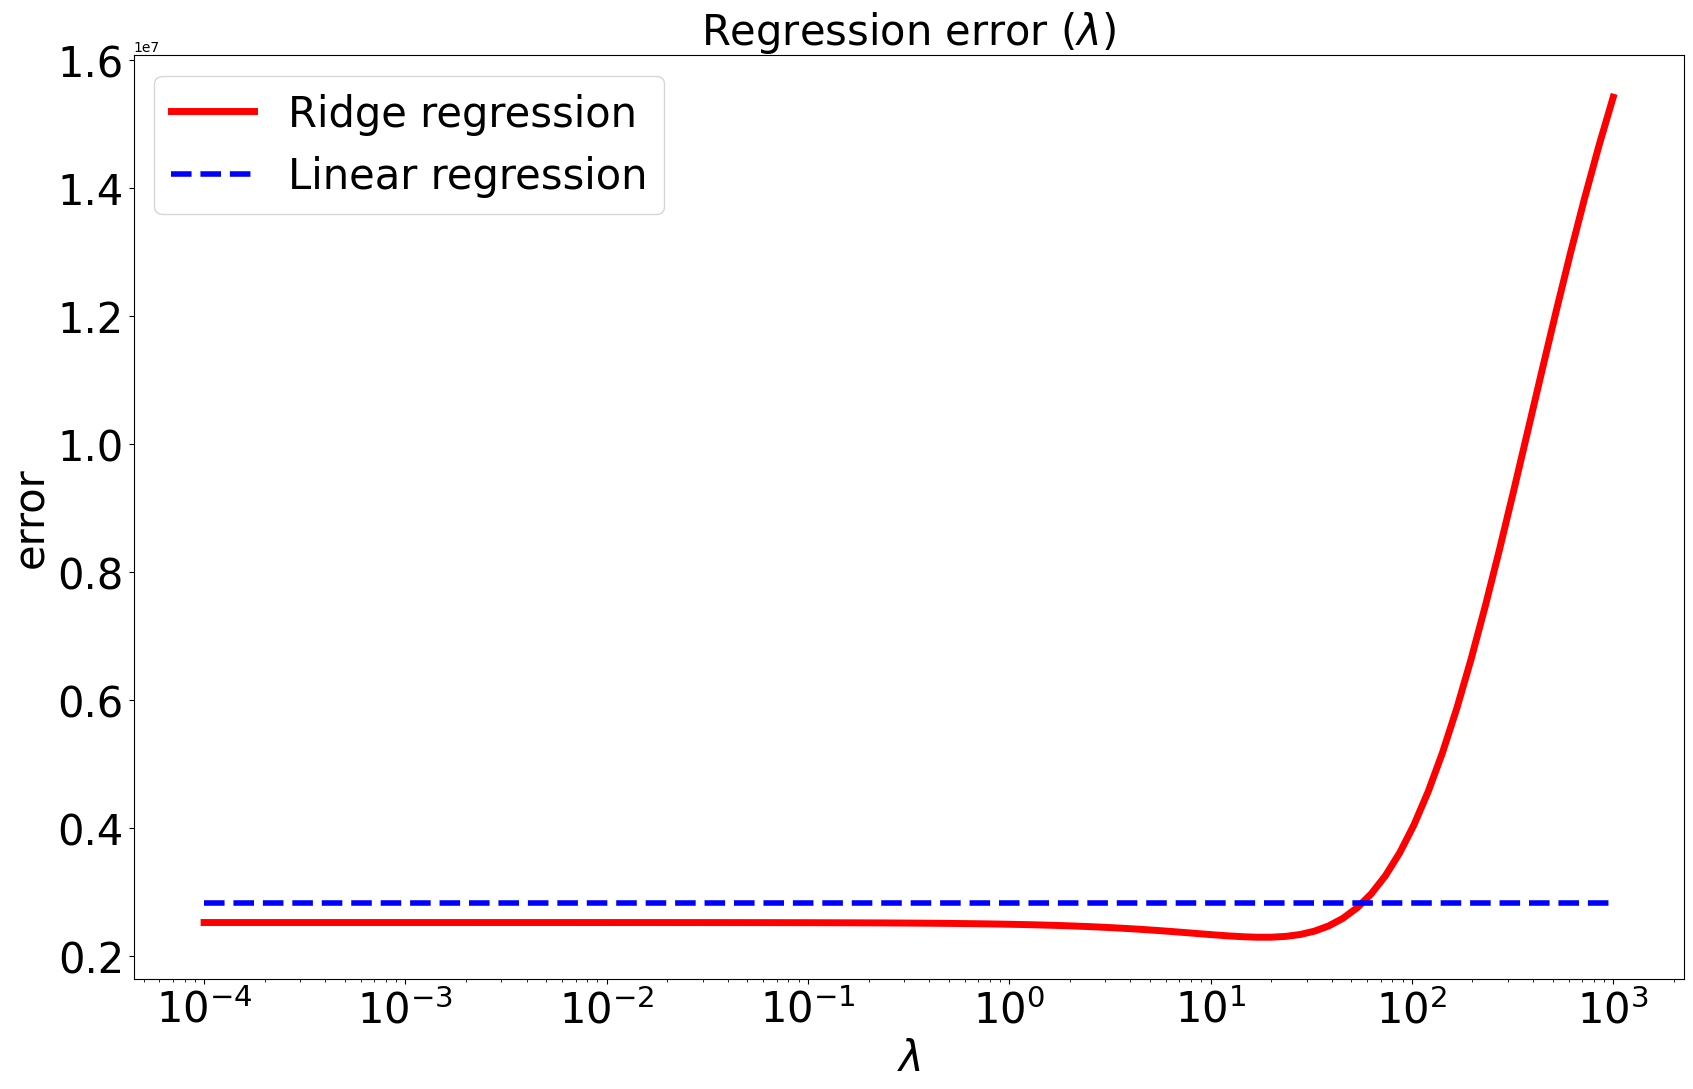

In [240]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, err_ridge, linewidth=5, color='red', label="Ridge regression")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\lambda$)', fontsize=30)
plt.show()

# (Explicación contaminación entre train y test)

## Resultados